**All the text cleaning done by a Package called Clean-text**

In [1]:
!pip install clean-text

In [2]:
#!pip install --upgrade pip setuptools wheel
#!pip install -I tensorflow
#!pip install -I keras

**Importing all the libraries**

In [3]:
import json
import keras
import numpy as np
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
import re
import csv
import codecs
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from cleantext import clean
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model

Using TensorFlow backend.


**A generic function which returns the cleaned text after applying several transformations**

In [5]:
def preprocess_text(text):
        text = clean(text,fix_unicode=True,               # fix various unicode errors
            to_ascii=True,                  # transliterate to closest ASCII representation
            lower=True,                     # lowercase text
            no_line_breaks=False,           # fully strip line breaks as opposed to only normalizing them
            no_urls=True,                  # replace all URLs with a special token
            no_emails=True,                # replace all email addresses with a special token
            no_phone_numbers=True,         # replace all phone numbers with a special token
            no_numbers=True,               # replace all numbers with a special token
            no_digits=True,                # replace all digits with a special token
            no_currency_symbols=True,      # replace all currency symbols with a special token
            no_punct=True,                 # fully remove punctuation
            replace_with_url="",
            replace_with_email="",
            replace_with_phone_number="",
            replace_with_number="",
            replace_with_digit="",
            replace_with_currency_symbol="",
            lang="en"                       # set to 'de' for German special handling
        )
        whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
        text = ''.join(filter(whitelist.__contains__, text))    
        
        return text

**Loading json data collected by scrapping data from Reddit**

In [6]:
file1 = open('../input/scraped-data/scraped_data.json',) 
data1 = json.load(file1) 

file2 = open('../input/json-files/additional_data_1.json',) 
data2 = json.load(file2) 

In [7]:
flair_wise_dict = {"AskIndia":[], "Non-Political":[], "Science/Technology":[], "Coronavirus":[],"Politics":[],"Business/Finance":[], "Policy/Economy":[],"Sports":[], "Food":[]}
num_of_records = len(data1['flair'])  
for it in range(num_of_records):
    flair = data1['flair'][it]
    content = data1['body'][it]
    title = data1['title'][it]
    flair_wise_dict[flair].append(title+" "+content)
num_of_records = len(data2['flair'])
for it in range(num_of_records):
    flair = data2['flair'][it]
    content = data2['body'][it]
    title = data2['title'][it]
    flair_wise_dict[flair].append(title+" "+content)

In [8]:
flair_wise_dict['Business/Finance'] = flair_wise_dict['Business/Finance'] + flair_wise_dict['Policy/Economy']


In [9]:
del flair_wise_dict['Policy/Economy']

In [10]:
X = []
Y = []

**Feeding in data for training and testing **

In [11]:
max_length = 0
for flair,content in flair_wise_dict.items():
     if len(content)<1500:
        for text in content:
            cleaned_text = preprocess_text(text)
            max_length = max(max_length,len(re.findall(r'\w+', cleaned_text)))
            if len(cleaned_text)>0:
                X.append(cleaned_text)
                Y.append(flair)
     else:
         body = content[len(content)-1500:]
         for text in body:
            cleaned_text = preprocess_text(text)
            max_length = max(max_length,len(re.findall(r'\w+', cleaned_text)))
            if len(cleaned_text)>0:
                X.append(cleaned_text)
                Y.append(flair)
     

**Total data size**

In [12]:
print(len(X),len(Y))


9426 9426


**Creating dictionary for words from Glove embeddings**

In [13]:
BASE_DIR = '../input/'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove6b')
print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))



Indexing word vectors.
Found 400000 word vectors.


**Hyperparameters**

In [14]:
MAX_NUM_WORDS= 100000
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 2000

In [15]:
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [16]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 58276 unique tokens.


In [17]:
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [18]:
reverse_dict = {}
index = 0
for k,v in flair_wise_dict.items():
    reverse_dict[k] = index
    index+=1

print(reverse_dict)

{'AskIndia': 0, 'Non-Political': 1, 'Science/Technology': 2, 'Coronavirus': 3, 'Politics': 4, 'Business/Finance': 5, 'Sports': 6, 'Food': 7}


In [19]:
for index in range(len(Y)):
    Y[index] = reverse_dict[Y[index]]

In [20]:
Y = to_categorical(np.asarray(Y))

**Splitting into train and test set**

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.1)

**Preparing embedding matrix.**

In [22]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.


**Model Definitions and Architecture**

In [23]:
model = Sequential()
model.add(Embedding(num_words, output_dim = EMBEDDING_DIM,weights=[embedding_matrix],trainable=True, input_length= MAX_SEQUENCE_LENGTH))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(reverse_dict), activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 100)         5827700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 808       
Total params: 5,908,908
Trainable params: 5,908,908
Non-trainable params: 0
_________________________________________________________________
None


**Training Model**

In [24]:

history = model.fit(X_train, Y_train,
          epochs=10,
          batch_size = 128,
          validation_data=(X_test, Y_test))

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8483 samples, validate on 943 samples
Epoch 1/10
8483/8483 [==============================] - 167s 20ms/step - loss: 0.3506 - accuracy: 0.8754 - val_loss: 0.3194 - val_accuracy: 0.8812
Epoch 2/10
8483/8483 [==============================] - 164s 19ms/step - loss: 0.3173 - accuracy: 0.8805 - val_loss: 0.2896 - val_accuracy: 0.8888
Epoch 3/10
8483/8483 [==============================] - 167s 20ms/step - loss: 0.2885 - accuracy: 0.8878 - val_loss: 0.2690 - val_accuracy: 0.8955
Epoch 4/10
8483/8483 [==============================] - 167s 20ms/step - loss: 0.2605 - accuracy: 0.8957 - val_loss: 0.2527 - val_accuracy: 0.9002
Epoch 5/10
8483/8483 [==============================] - 167s 20ms/step - loss: 0.2342 - accuracy: 0.9056 - val_loss: 0.2441 - val_accuracy: 0.9003
Epoch 6/10
8483/8483 [==============================] - 166s 20ms/step - loss: 0.2091 - accuracy: 0.9151 - val_loss: 0.2336 - val_accuracy: 0.9026
Epoch 7/10
8483/8483 [==============================] - 164s 19ms/step 

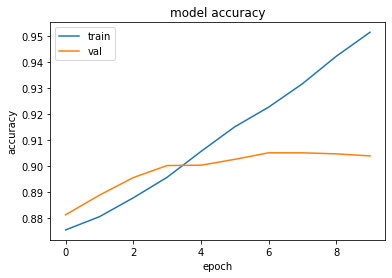

In [25]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

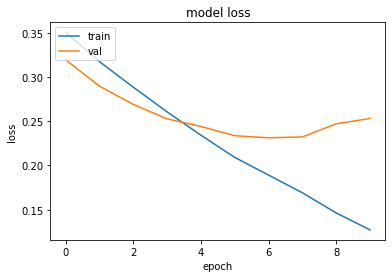

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
model.save_weights('my_model_weights.h5')